In [3]:
import requests

import cv2
import numpy
from google.colab.patches import cv2_imshow
from IPython.display import Image

In [54]:
img_path = '/content/keszthelyi-timi-P25wpQ8ndl8-unsplash.jpg';
img_edited_path = '/content/keszthelyi-timi-P25wpQ8ndl8-unsplash_edited.jpg';

#img_url = 'https://images.unsplash.com/photo-1589828155685-83225f7d91f3?ixid=MXwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHw%3D&ixlib=rb-1.2.1&auto=format&fit=crop&w=2153&q=80'
img_url = 'https://images.unsplash.com/photo-1595365409261-4f1c3a8c9282?ixid=MXwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHw%3D&ixlib=rb-1.2.1&auto=format&fit=crop&w=1950&q=80'
open(img_path, 'wb').write(requests.get(img_url, allow_redirects = True).content)

754023

In [5]:
yolo_weights_url = 'https://pjreddie.com/media/files/yolov3.weights'
#yolo_weights_url = 'https://pjreddie.com/media/files/yolov3-tiny.weights'
yolo_weights_path = '/content/yolo.weights'
open(yolo_weights_path, 'wb').write(requests.get(yolo_weights_url, allow_redirects = True).content)

248007048

In [6]:
yolo_config_url = 'https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg'
#yolo_config_url = 'https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3-tiny.cfg'
yolo_config_path = '/content/yolo.cfg'
open(yolo_config_path, 'wb').write(requests.get(yolo_config_url, allow_redirects = True).content)
yolo_frame = (608, 608)
#yolo_frame = (416, 416)

In [7]:
coco_names_url = 'https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names'
coco_names_path = '/content/coco.names'
open(coco_names_path, 'wb').write(requests.get(coco_names_url, allow_redirects = True).content)

objects = [line for line in open(coco_names_path, 'r').read().split('\n') if line]
colors = numpy.random.uniform(0, 255, size=(len(objects), 3))

In [50]:
ai = cv2.dnn.readNet(yolo_config_path, yolo_weights_path)
layers_names = ai.getLayerNames()
output_layers = [layers_names[i[0] - 1] for i in ai.getUnconnectedOutLayers()]

def draw_object(img, to_draw):
  width = 1;
  color = to_draw['class']['color']
  
  pt1 = (to_draw['box'][0], to_draw['box'][1])
  pt2 = (pt1[0] + to_draw['box'][2], pt1[1] + to_draw['box'][2])
  img = cv2.rectangle(img, pt1, pt2, color, width)
  #
  #pt3 = (pt1[0], pt1[1])
  #pt4 = (pt2[0], pt1[1] - 40)
  #img = cv2.rectangle(img, pt3, pt4, color, width)
  #img = cv2.rectangle(img, pt3, pt4, color, -1)
  #
  #pt5 = (pt3[0] + 10, pt4[1] + 30)
  #img = cv2.putText(img, "{0} ({1:.0%})".format(to_draw['class']['name'], to_draw['confidence']), pt5, cv2.FONT_HERSHEY_SIMPLEX, 1, [255 - x for x in color], 3)
  
  return img;

def get_detected_objects_in_frame(frame, confidence_threshold = 0.8, filter_by_class = lambda x: True):
  centers = [];
  boxes = [];
  confs = [];
  class_ids = [];

  height = frame.shape[0]
  width = frame.shape[1]

  ai.setInput(cv2.dnn.blobFromImage(frame, 1/255, yolo_frame, (0, 0, 0), swapRB = True, crop = False))
  outputs = ai.forward(output_layers)
  for output in outputs:
    for detect in output:
      scores = detect[5:]
      class_id = numpy.argmax(scores)
      conf = scores[class_id] * 1.0
      if conf >= confidence_threshold:
        if filter_by_class(objects[class_id]):
          center_x = int(detect[0] * width)
          center_y = int(detect[1] * height)
          
          centers.append([center_x, center_y]);
          
          w = int(detect[2] * width)
          h = int(detect[3] * height)
          x = int(center_x - w / 2)
          y = int(center_y - h / 2)
        
          boxes.append([x, y, w, h])
          confs.append(float(conf))
          class_ids.append(class_id)
  # filter out NMS probes
  centers, boxes, confs, class_ids = [[arr[i] for i in [x[0] for x in cv2.dnn.NMSBoxes(boxes, confs, 0, 0.45)]] for arr in [centers, boxes, confs, class_ids]];

  detected_objects = [{'center': centers[idx], 'box': boxes[idx], 'class': {'name': objects[class_ids[idx]], 'color': colors[class_ids[idx]]}, 'confidence': confs[idx]} for idx in range(0, len(boxes))]
  return detected_objects

def get_detected_objects(img, confidence_threshold = 0.8, filter_by_class = lambda x: True):
  # first, pass over whole image
  detected_objects = get_detected_objects_in_frame(img, confidence_threshold, filter_by_class);
  # second, split image in frames and pass one by one
  if(img.shape[0] > yolo_frame[1] or img.shape[1] > yolo_frame[0]):
    frame_height = yolo_frame[1];
    frame_height_half = frame_height // 2;
    frames_per_height = img.shape[0] // frame_height_half;
    frame_width = yolo_frame[0];
    frame_width_half = frame_width // 2;
    frames_per_width = img.shape[1] // frame_width_half;
    for i in range(frames_per_height):
      frame_x1 = i * frame_height_half;
      frame_x2 = min(frame_x1 + frame_height, img.shape[0])
      for j in range(frames_per_width):
        frame_y1 = j * frame_width_half;
        frame_y2 = min(frame_y1 + frame_width, img.shape[1])
        print(i, frame_x1, frame_x2, j, frame_y1, frame_y2)
        frame = img[frame_x1:frame_x2, frame_y1:frame_y2]
        # detect objects in frame
        detected_objects_from_frame = get_detected_objects_in_frame(frame, confidence_threshold, filter_by_class);
        # adjust according to frame start
        for obj in detected_objects_from_frame:
          obj['center'][0] += frame_y1;
          obj['center'][1] += frame_x1;
          obj['box'][0] += frame_y1;
          obj['box'][1] += frame_x1
        # mix up
        detected_objects += detected_objects_from_frame;
        # nms with already detected
        detected_objects = [detected_objects[i] for i in [x[0] for x in cv2.dnn.NMSBoxes([obj['box'] for obj in detected_objects], [obj['confidence'] for obj in detected_objects], 0, 0.1)]]

  return detected_objects;

def apply_yolo(img, detection_downscale = 1.1, detection_confidence_threshold = 0.8, detection_filter_by_class = lambda x: True):
  img_to_detect = img;
  if(detection_downscale != 1):
    img_to_detect = cv2.resize(img, (int(img.shape[1] / detection_downscale), int(img.shape[0] / detection_downscale)));

  for obj in get_detected_objects(img_to_detect, detection_confidence_threshold, detection_filter_by_class):
    # adjust for downscale
    if(detection_downscale != 1):
      obj['center'] = [int(x * detection_downscale) for x in obj['center']];
      obj['box'] = [int(x * detection_downscale) for x in obj['box']];
    # draw box
    img = draw_object(img, obj)
  return img;


0 0 608 0 0 608
0 0 608 1 304 912
0 0 608 2 608 1216
0 0 608 3 912 1520
0 0 608 4 1216 1772
1 304 912 0 0 608
1 304 912 1 304 912
1 304 912 2 608 1216
1 304 912 3 912 1520
1 304 912 4 1216 1772
2 608 1216 0 0 608
2 608 1216 1 304 912
2 608 1216 2 608 1216
2 608 1216 3 912 1520
2 608 1216 4 1216 1772
3 912 1520 0 0 608
3 912 1520 1 304 912
3 912 1520 2 608 1216
3 912 1520 3 912 1520
3 912 1520 4 1216 1772
4 1216 1824 0 0 608
4 1216 1824 1 304 912
4 1216 1824 2 608 1216
4 1216 1824 3 912 1520
4 1216 1824 4 1216 1772
5 1520 2128 0 0 608
5 1520 2128 1 304 912
5 1520 2128 2 608 1216
5 1520 2128 3 912 1520
5 1520 2128 4 1216 1772
6 1824 2363 0 0 608
6 1824 2363 1 304 912
6 1824 2363 2 608 1216
6 1824 2363 3 912 1520
6 1824 2363 4 1216 1772


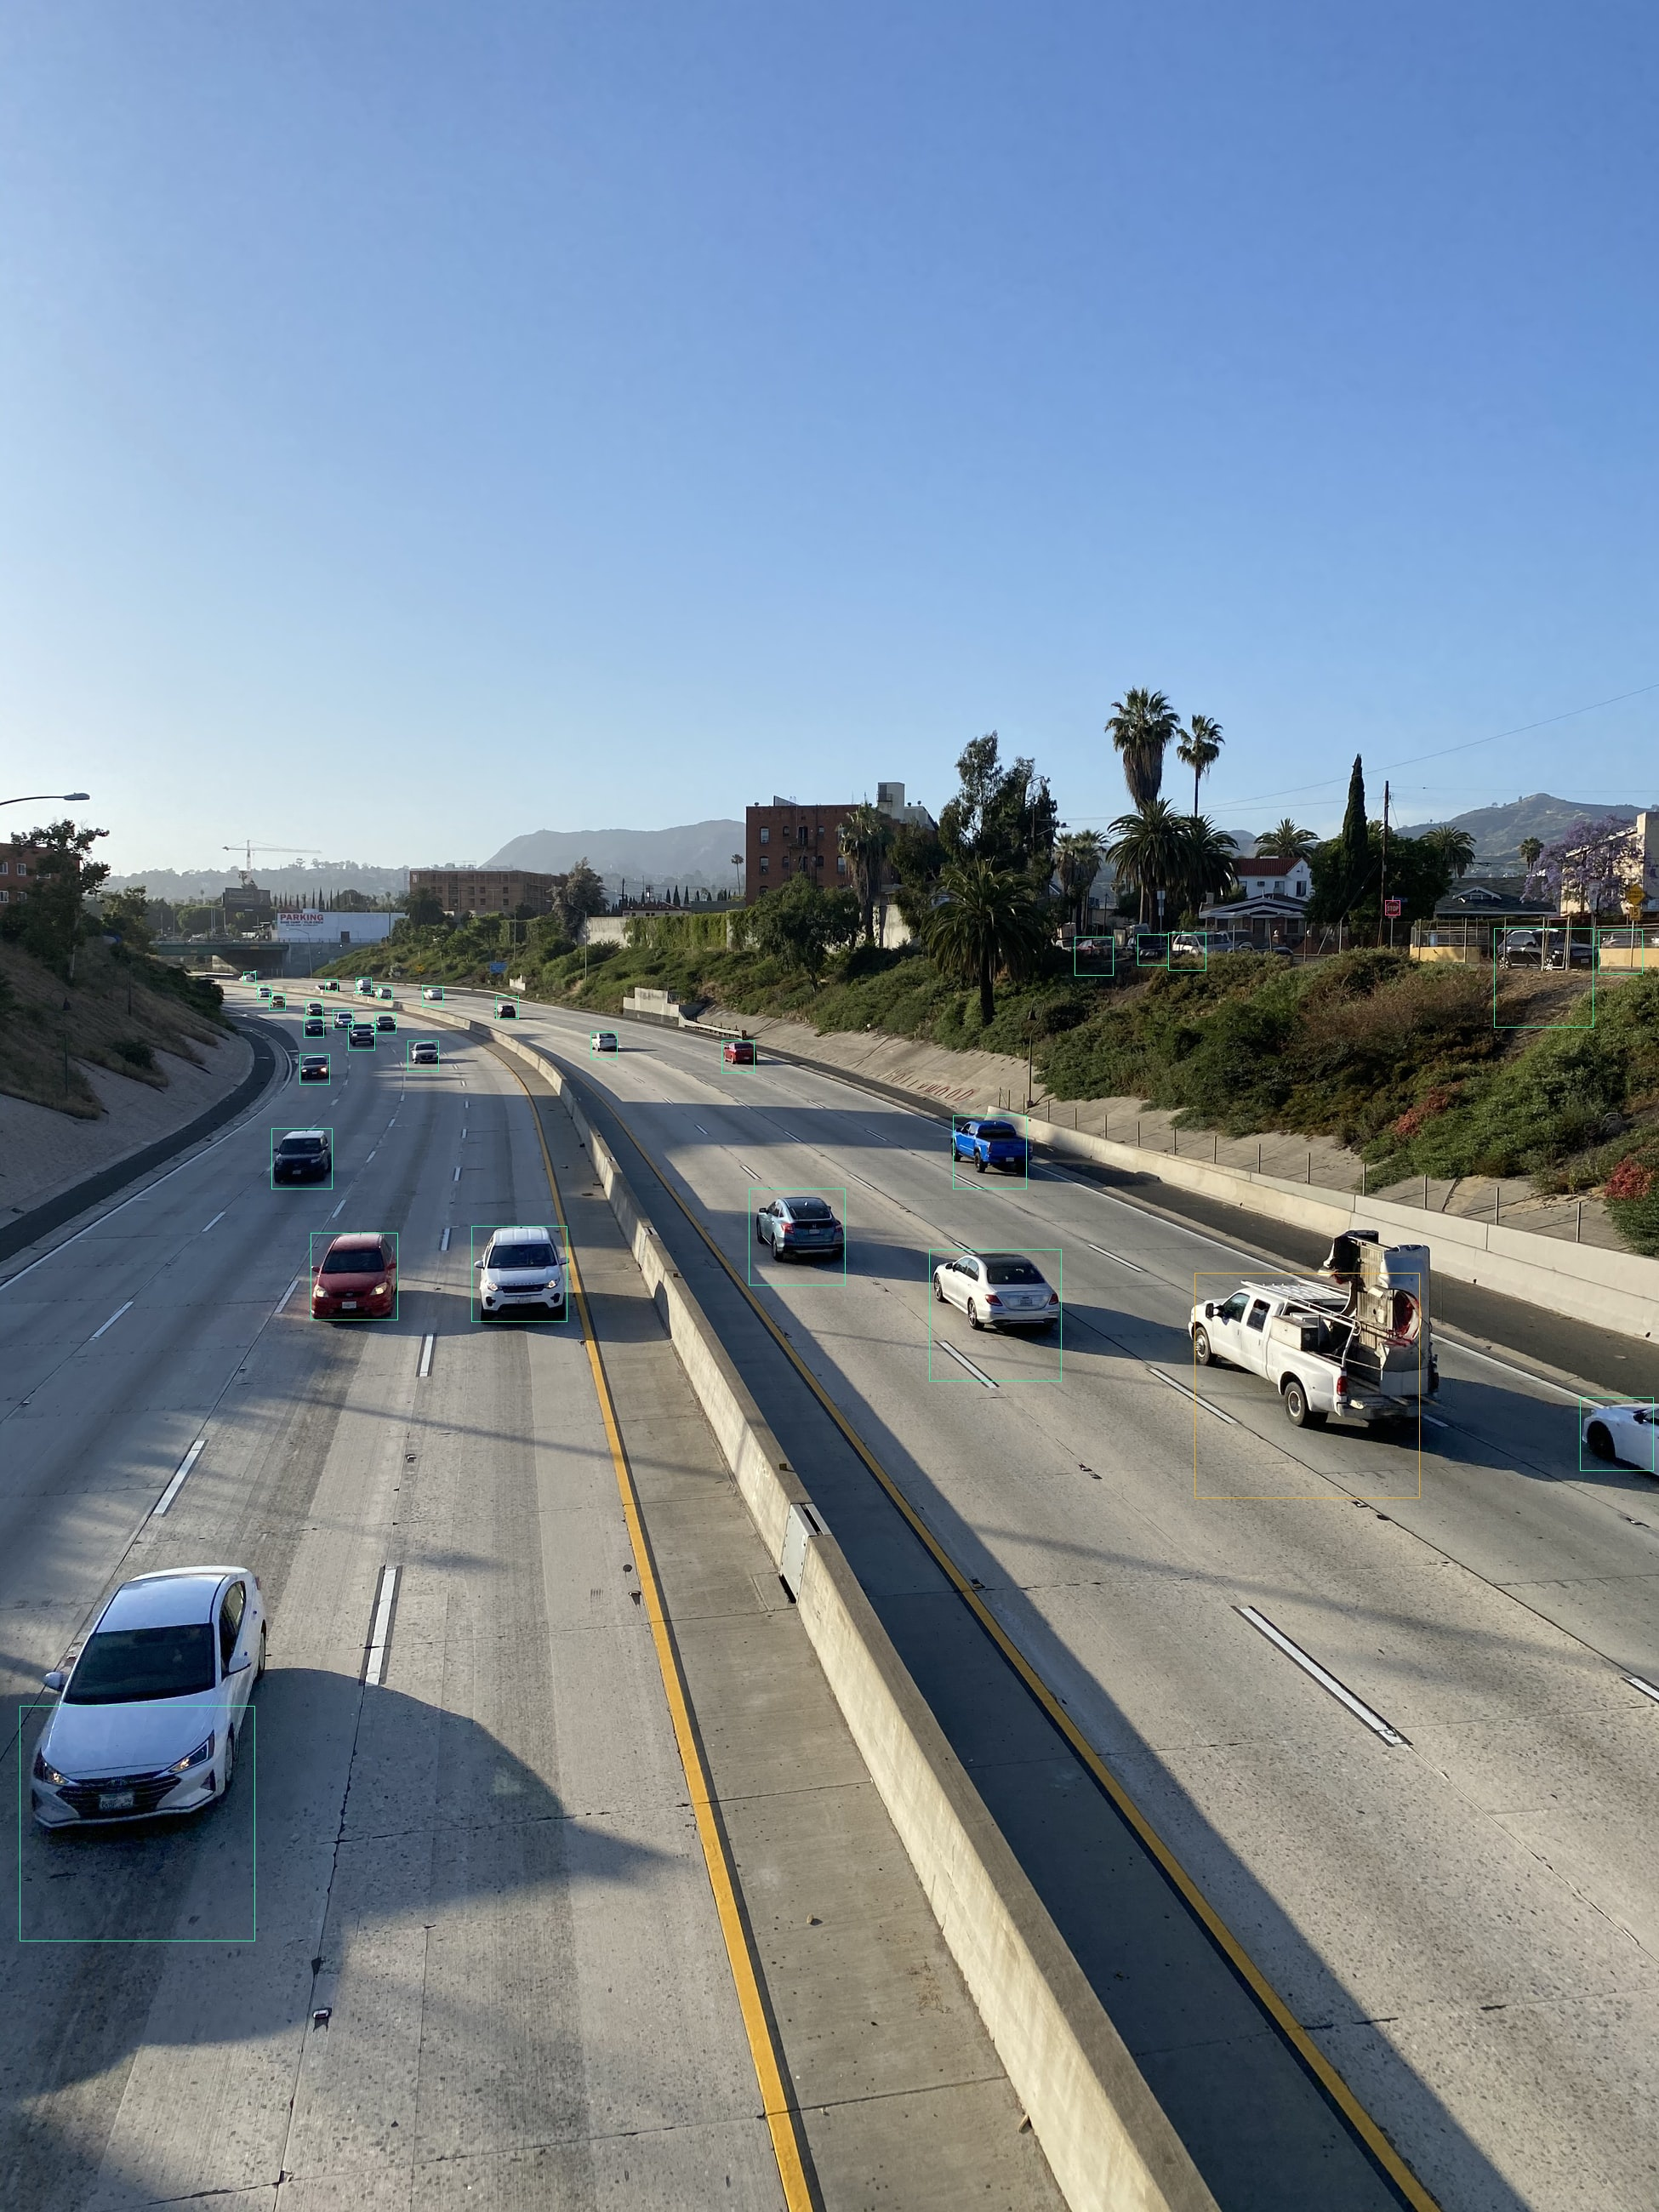

In [55]:
img = cv2.imread(img_path)
#img_downsize = 1.1
#img = cv2.resize(img, (int(img.shape[1] / img_downsize), int(img.shape[0] / img_downsize)), interpolation = cv2.INTER_AREA)
img = apply_yolo(img, 1.1, 0.5)
cv2.imwrite(img_edited_path, img)
Image(img_edited_path)